# Portfolio Analysis Problem Set: Question 1

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import stats

In [57]:
df = pd.read_csv('2003_data.csv', index_col=0)
securities = df.loc[:, 'Agric':'Other']
market = df.loc[:, 'SP500']
interest = df.loc[:, 'LIBOR']

## Part (a)

In [58]:
mu = securities.mean()
cov = securities.cov()

## Part (b)

In [59]:
# Naive portfolio
naive = securities.mean(axis=1)
mu_naive = naive.mean()
sigma_naive = naive.std()

In [60]:
# Market portfolio
mu_market = market.mean()
sigma_market = market.std()

In [61]:
# Minimum variance portfolio
sigma_mvp = 1 / np.linalg.inv(cov).sum()
weights_mvp = sigma_mvp**2 * np.linalg.inv(cov) @ np.ones(cov.shape[0])
mu_mvp = mu @ weights_mvp

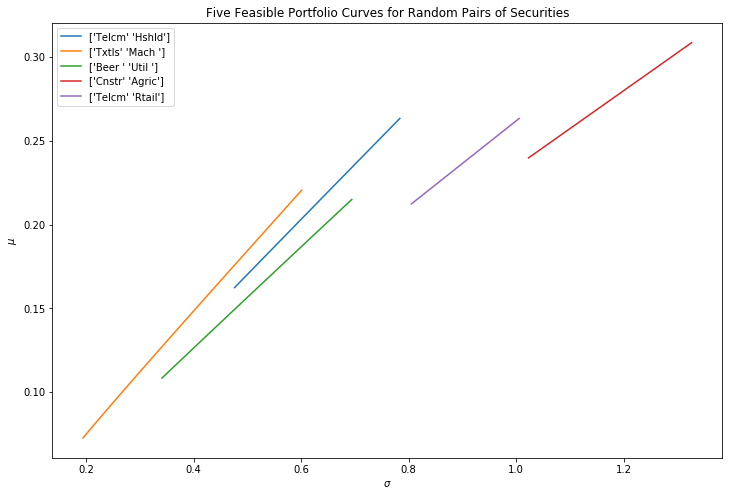

In [62]:
# Plot feasible portfolio curves for 5 random pairs of securities
mu_list = []
sigma_list = []
choices_list = []
for _ in range(5):
    choices = np.random.choice(securities.columns, 2, replace=False)

    mus = securities[choices].mean()
    sigmas = securities[choices].std()
    rho, _ = stats.pearsonr(securities[choices[0]], securities[choices[1]])
    A_sq = np.sqrt((sigmas[0]**2 + sigmas[1]**2 - 2*rho*sigmas[0]*sigmas[1]) / (mus[0] - mus[1]) ** 2)
    
    mu_v = np.linspace(mus.min(), mus.max())
    sigma_v = np.sqrt(sigma_mvp**2 + A_sq * (mu_v - mu_mvp)**2)

    mu_list.append(mu_v)
    sigma_list.append(sigma_v)
    choices_list.append(str(choices))

plt.figure(figsize=[12, 8])
for mu_v, sigma_v in zip(mu_list, sigma_list):
    plt.plot(sigma_v, mu_v)

plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('Five Feasible Portfolio Curves for Random Pairs of Securities')
plt.legend(choices_list);

## Part (c)

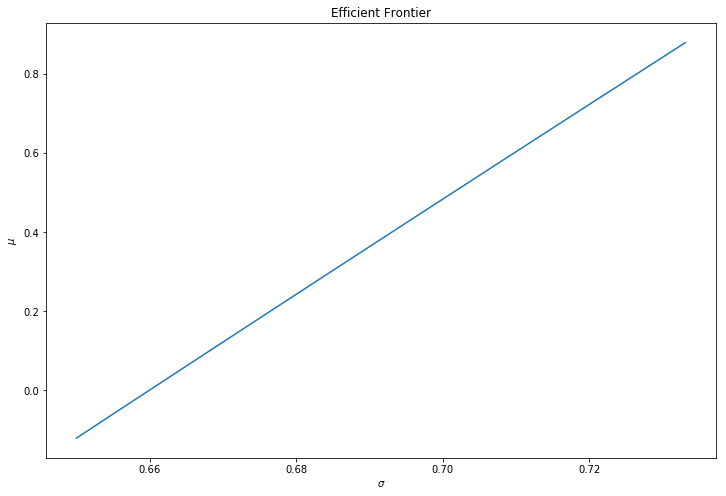

In [63]:
# Compute and graph efficient frontier
m_tilde = np.vstack([mu, np.ones(mu.shape)]).T
B = m_tilde.T @ np.linalg.inv(cov) @ m_tilde
G = np.linalg.inv(B) @ m_tilde.T @ np.linalg.inv(cov) @ m_tilde @ np.linalg.inv(B)
a, d, _, b = G.flatten()

mu_mvp = d / a
sigma_mvp = np.sqrt(np.linalg.det(G) / a)

mus = np.linspace(mu_mvp, mu_mvp + 1)  # A bit of kludge here...
sigmas = np.sqrt(a*(mu_v - d/a)**2 + (1/a)*np.linalg.det(G))

plt.figure(figsize=[12, 8])
plt.plot(sigmas, mus)
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
plt.title('Efficient Frontier');

## Part (d)

In [64]:
choices = np.random.choice(mu_v.shape[0], 3, replace=False)

# Find indices that sort the chosen mu_v's
indices = np.argsort(mu_v[choices])

# Check if the sorted sigma_v's are increasing (i.e. positive differences)
increasing = (np.diff(sigma_v[choices][indices]) > 0).all()

msg = 'Increasing mus imply increasing sigmas.' if increasing else 'Increasing mus do NOT imply increasing sigmas!'
print(msg)

Increasing mus imply increasing sigmas.


In [65]:
def mu_to_weights(mu):
    mu_tilde = np.vstack([mu, 1])
    return (np.linalg.inv(cov) @ m_tilde @ np.linalg.inv(B) @ mu_tilde).flatten()


mu1, mu2, mu3 = mu_v[choices]
sigma1, sigma2, sigma3 = sigma_v[choices][indices]  # For part (g)

w1 = mu_to_weights(mu1)
w2 = mu_to_weights(mu2)
w3 = mu_to_weights(mu3)

In [66]:
# For the first security, solve the equation alpha*w1 + (1-alpha)*w3 = w2
# This alpha should work for all securities.
alpha = (w2[0] - w3[0]) / (w1[0] - w3[0])

is_combo = np.allclose(alpha*w1 + (1-alpha)*w3, w2)
msg = 'w2 is a convex combination of w1 and w3.' if is_combo else 'w2 is NOT a convex combination of w1 and w3!'
print(msg)

w2 is a convex combination of w1 and w3.


## Part (e)

In [67]:
R = interest.mean()

msg = 'R < mu_mvp.' if R < mu_mvp else 'R is NOT < mu_mvp!'
print(msg)

R is NOT < mu_mvp!


## Part (f)

In [68]:
R = interest.mean()
mu_M = market.mean()
sigma_M = market.std()

sigmas = np.linspace(0, 1)
mus = R + ((mu_M - R) / sigma_M) * sigmas  # Capital Market Line

## Part (g)

In [69]:
def weights_to_beta(weights):
    returns_portfolio = (weights * securities).sum(axis=1)
    # np.cov returns cov matrix; get the diagonal element
    cov = np.cov(returns_portfolio, market)[0, 1]
    beta = cov / sigma_M**2
    return beta, returns_portfolio  # Return portfolio returns for part (h)

In [70]:
beta_mvp, returns_mvp = weights_to_beta(weights_mvp)
beta1, returns1 = weights_to_beta(w1)
beta2, returns2 = weights_to_beta(w2)
beta3, returns3 = weights_to_beta(w3)
beta_naive, returns_naive = weights_to_beta(np.ones(48) / 48)

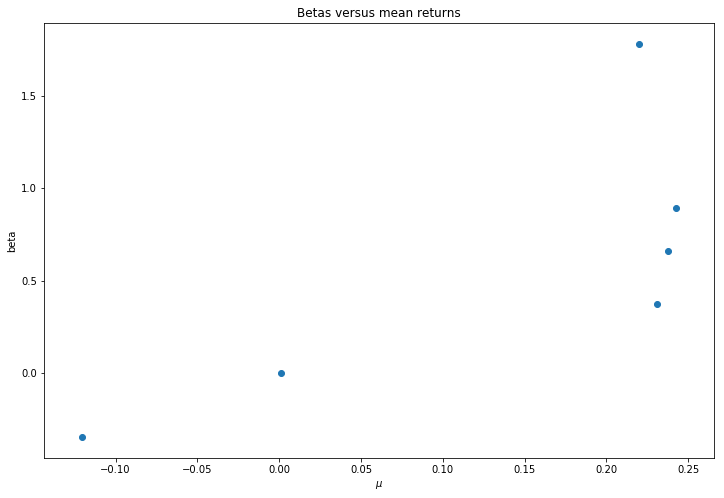

In [71]:
fig = plt.figure(figsize=[12, 8])
mus = [mu_M, mu_mvp, mu1, mu2, mu3, mu_naive]
betas = [0, beta_mvp, beta1, beta2, beta3, beta_naive]
plt.scatter(mus, betas)
plt.title('Betas versus mean returns')
plt.xlabel('$\mu$')
plt.ylabel('beta');

## Part (h)

In [72]:
equity_market = (1+market).cumprod()
equity_naive = (1+returns_naive).cumprod()
equity_mvp = (1+returns_mvp).cumprod()

equity1 = (1+returns1).cumprod()
equity2 = (1+returns2).cumprod()
equity3 = (1+returns3).cumprod()

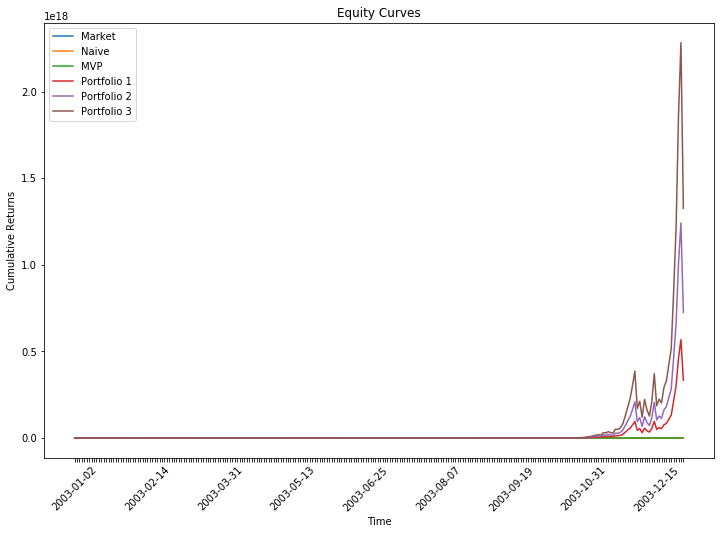

In [73]:
fig = plt.figure(figsize=[12, 8])

plt.plot(equity_market, label='Market')
plt.plot(equity_naive, label='Naive')
plt.plot(equity_mvp, label='MVP')
plt.plot(equity1, label='Portfolio 1')
plt.plot(equity2, label='Portfolio 2')
plt.plot(equity3, label='Portfolio 3')

# Ugly hack to only show one x tick for every 30 days
for index, label in enumerate(fig.axes[0].xaxis.get_ticklabels()):
    if index % 30 != 0:
        label.set_visible(False)
    
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Equity Curves')
plt.xticks(rotation=45)
plt.legend();